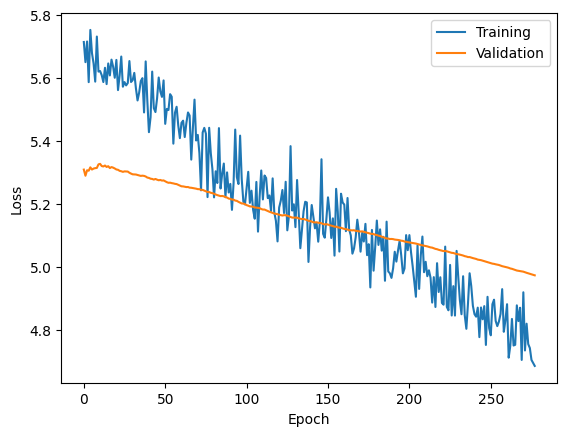

In [3]:
from sim_clr.sim_clr_train import plot_validation_loss
plot_validation_loss(r'C:\Users\Jack\Documents\coding\contrastive\src\lightning_logs\version_22')

In [59]:
annotation_path = r"..\data\Lemon\annotations\instances_default.json"
image_path = "..\data\Lemon\images"

with open(annotation_path) as f:
    annotations = json.load(f)

labels = [(e["image_id"], e["category_id"]) for e in annotations["annotations"]]
category_names = [(e["id"], e["name"]) for e in annotations["categories"]]
labels_df = pd.DataFrame(labels, columns=["image_id", "Category id"])
# labels_df.set_index("id", inplace=True)
category_names_df = pd.DataFrame(category_names, columns=["Category id", "Label"])
category_names_df.set_index("Category id", inplace=True)


In [60]:
labels_named_df = pd.merge(labels_df, category_names_df, "left", "Category id").drop("Category id", axis=1)
labels_named_df.set_index("image_id", inplace=True)
labels_named_df

,Label
image_id,
0,pedicel
0,blemish
0,blemish
100,blemish
100,illness
...,...
6502,blemish
6502,blemish
6502,blemish


In [61]:
labels_named_df[labels_named_df["Label"]=="condition"]

,Label
image_id,
2166,condition
3400,condition


In [ ]:
train_loss = callback.train_losses
val_loss = callback.val_losses

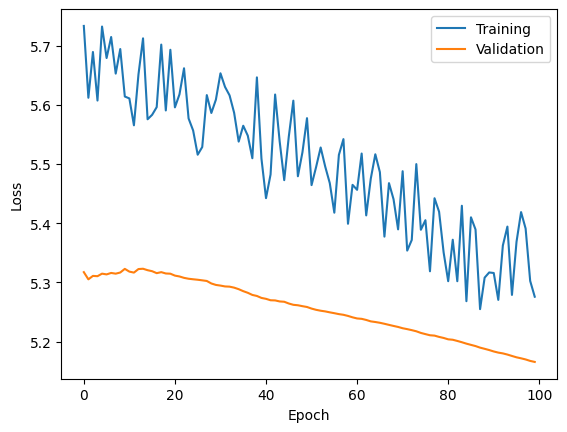

In [ ]:
fig, ax = plt.subplots(1,1)

epochs = range(len(train_loss))
ax.plot(epochs, train_loss)
ax.plot(epochs, val_loss)
ax.set_title(f"{path_to_weights} loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.savefig(f'app/loss/{path_to_weights}.png')
ax

In [63]:
import os
from lightly.data import LightlyDataset
from lightly.embedding import SelfSupervisedEmbedding
from lightly.loss import NTXentLoss
from lightly.models import ResNetGenerator
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead
from sklearn.metrics import roc_curve, precision_recall_curve, auc

import os

import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils
# Set the path to your dataset
# data_path = '/path/to/your/dataset'


# Initialize a ResNet model from lightly
resnet = ResNetGenerator('resnet-18', num_classes=len(category_names_df))


# Define the loss function (NTXentLoss)
criterion = NTXentLoss()

# Define the optimizer
# optimizer = torch.optim.Adam(embedding_model.parameters(), lr=3e-4)

# Initialize the self-supervised embedding model
embedding_model = SelfSupervisedEmbedding(resnet, NTXentLoss(), torch.optim.Adam, loader)

# Save the trained model

In [68]:
import pytorch_lightning as pl
import torch
import torchvision
from torch import nn

from lightly.data import LightlyDataset
from lightly.models import utils
from lightly.models.modules import masked_autoencoder
from lightly.transforms.mae_transform import MAETransform  # Same transform as MAE
import copy

import torch
import torchvision
from torch import nn

from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.dino_transform import DINOTransform
from lightly.utils.scheduler import cosine_schedule


class DINO(torch.nn.Module):
    def __init__(self, backbone, input_dim):
        super().__init__()
        self.student_backbone = backbone
        self.student_head = DINOProjectionHead(
            input_dim, 512, 64, 2048, freeze_last_layer=1
        )
        self.teacher_backbone = copy.deepcopy(backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)

    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z


resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
input_dim = 512
# instead of a resnet you can also use a vision transformer backbone as in the
# original paper (you might have to reduce the batch size in this case):
# backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
# input_dim = backbone.embed_dim

model = DINO(backbone, input_dim)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

transform = DINOTransform()
dataset = LightlyDataset(image_path,transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = DINOLoss(
    output_dim=2048,
    warmup_teacher_temp_epochs=5,
)
# move loss to correct device because it also contains parameters
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10

print("Starting Training")
for epoch in range(epochs):
    total_loss = 0
    momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
    for batch in dataloader:
        views = batch[0]
        update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
        update_momentum(model.student_head, model.teacher_head, m=momentum_val)
        views = [view.to(device) for view in views]
        global_views = views[:2]
        teacher_out = [model.forward_teacher(view) for view in global_views]
        student_out = [model.forward(view) for view in views]
        loss = criterion(teacher_out, student_out, epoch=epoch)
        total_loss += loss.detach()
        loss.backward()
        # We only cancel gradients of student head.
        model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

c:\Users\Morri\Documents\Notebooks\AI\contrastive\.venv\lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Starting Training
epoch: 00, loss: 8.05545
epoch: 01, loss: 7.50374
epoch: 02, loss: 7.48619
epoch: 03, loss: 7.56141
epoch: 04, loss: 7.59193


KeyboardInterrupt: 